## Dynamic of active colloids in a lattice of harmonic traps

Here, we study the dynamics of active colloids in a two-dimensional lattice of traps. We consider self-propelling, polar, achiral active colloids, with non-zero values of $\mathbf{V}_{i}^{\mathcal{A}}, \mathbf{V}_{i}^{(2s)}$ and $\mathbf{V}_{i}^{(3t)}$.  With this choice, an isolated colloid translates with velocity $\mathbf{V}_{i}^{\mathcal{A}}=v_{s}\boldsymbol{p}_{i}$ while producing dipolar and quadrupolar flows of strengths proportional to $\mathbf{V}_{i}^{(2s)}$ and $\mathbf{V}_{i}^{(3t)}$ respectively. 

The system we study can be realized experimentally in holographic tweezers. The centers of the $N$ traps are at $\boldsymbol{R}_{i}^{0}$, arranged linearly or in a $\sqrt{N}\times\sqrt{N}$ square lattice. Each trap contains a single active colloid which feels a body force from that trap alone. The moment of force about the trap center is zero. Therefore, in a trap of stiffness $k$ centered at $\boldsymbol{R}_{i}^{0}$, the force and torque on the ith colloid is

$$
\mathbf{F}_{i}^{P}=-k(\boldsymbol{R}_{i}-\boldsymbol{R}_{i}^{0}),\qquad\mathbf{T}_{i}^{P}=0.
$$

We start by ignoring hydrodynamic interactions to obtain the balance of forces and torques 

$$
-6\pi\eta b(\mathbf{V}_{i}-v_{s}\boldsymbol{p}_{i})-k(\boldsymbol{R}_{i}-\boldsymbol{R}^{0})	=0,	\qquad-8\pi\eta b^{3}\,\mathbf{\Omega}_{i}=0.
$$

This gives the confinement radius $R^{*}=6\pi\eta bv_{s}/k=\mathcal{A}_{T}b$, when the propulsive and trap forces are balanced. This is the stable state of the system in absence of hydrodynamic interactions. We now study the effects of hydrodynamic interaction. More details of the model etc can be found in section VII of the [paper](https://arxiv.org/pdf/1603.05735.pdf). We now study the dynamics using PyStokes.

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import sys
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
import trap   
# the file 'trap.pyx' contains the main code which implements the desired model using PyStokes

## parameters
Np = 9          # number of particles
vs = 0.1        # self-propulsion speed
A  = 2          # dimensionless number vs/k
k  = vs/A       # stiffness of the trap
a0 = 40         # separation of trap centers

dim = 3         # dimensionality of the problem 
eta = 1.0/6     # viscosity of the fluid simulated
b   = 1          # radius of the particle     

S0, D0         = 0.01, 0.01      # strength of the stresslet and potDiple
ljrmin, ljeps  = 3, .01         # lennard-jones parameters
Tf, Npts       = 400000, 5000   # final time and number of points 


# instantiate the class trap from trap.pyx for simulation                    
rm = trap.trap(b, Np, vs, eta, dim, S0, D0, k, ljeps, ljrmin)    

In [3]:
def initialConfig(rp0, trapCentre, theta, b, a0, vs, k, Np):                                              
    '''method for preparing an initial system'''                                                                           
    rr = (6*np.pi*eta*vs*b)/k  # confinement radius
    t1 = np.pi/180       
            
    if Np==1:                                                                                             
        rp0[0], rp0[1], rp0[2] = 0, 0, 8   # particle 1 Position                                          
        rp0[3], rp0[4], rp0[5] = 0, 0, -1   # Orientation                                                 
                
    elif Np==3: 
        t1 = np.pi/180
        trapCentre[0] =  0                                                                                
        trapCentre[1] =  a0
        trapCentre[2] = -a0
        trapCentre[3] =  0
        trapCentre[4] =  a0
        trapCentre[5] =  a0                                                                               
                
        theta[0] = 90*t1
        theta[1] = 90*t1
        theta[2] = 90*t1                                                                                  
        for i in range(Np):                                                                               
            rp0[i     ] =   trapCentre[i     ] + rr*np.cos(theta[i])
            rp0[i+Np  ] =   trapCentre[i+Np  ] + rr*np.sin(theta[i])
            rp0[i+3*Np] = np.cos(theta[i])
            rp0[i+4*Np] = np.sin(theta[i])

    else:
        Np1d = np.int(np.round( (Np)**(1.0/2)))
        nnd = Np1d/2 - 0.5; h0=0
        Np= Np1d*Np1d

        #2D initial
        for i in range(Np1d):
            for j in range(Np1d):
                    ii                  = i*Np1d + j
                    trapCentre[ii]      = a0*(-nnd + i)
                    trapCentre[ii+Np]   = a0*(-nnd + j)
                    trapCentre[ii+2*Np] = h0

        theta = np.ones(Np)*np.pi/2
        #theta = np.random.random(Np)*np.pi/2
        for i in range(Np):
            rp0[i     ] = trapCentre[i   ] + rr*np.cos(theta[i])
            rp0[i+Np  ] = trapCentre[i+Np] + rr*np.sin(theta[i])
            rp0[i+3*Np] = np.cos(theta[i])
            rp0[i+4*Np] = np.sin(theta[i])

In [4]:
## Main part of the simulation

# prepare the initial system
rp0        = np.zeros(6*Np)   # memory allocation for positions and orientation of colloids
trapCentre = np.zeros(3*Np)   # memory allocation for trap centers
theta      = np.zeros(Np)     # angle of the colloids about the trap centers

initialConfig(rp0, trapCentre, theta, b, a0, vs, k, Np)
rm.initialise(rp0, trapCentre)

# simulate the system thus prepared
rm.simulate(Tf, Npts)

/home/rsingh/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Load the data and plot snapshots

In [5]:
import scipy.io as sio
from scipy.signal import square

data  = sio.loadmat('Np=9_vs=0.1000_K=0.0500_trapA=40.0000.mat')
X     = data['X']
tm    = data['t']
k     = data['k']
vs    = data['vs']
Np    = data['Np']
tC    = data['trapCentre']

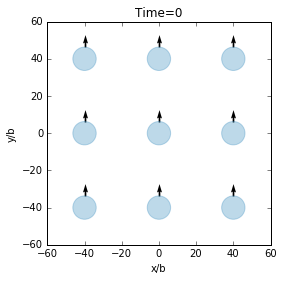

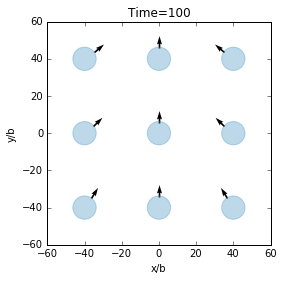

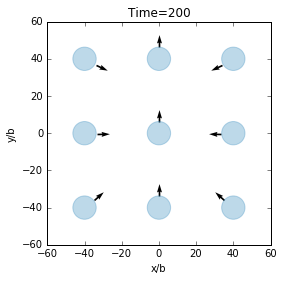

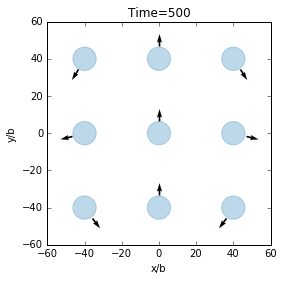

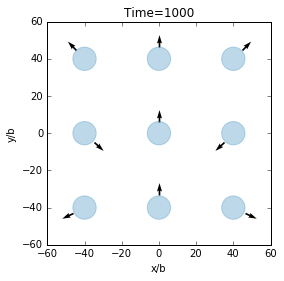

In [8]:
rr = (6*np.pi*eta*vs*b)/k  # confinement radius

def plotConfig(n):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, aspect='equal')
    for i in range(Np):
        ax1.add_patch(patches.Circle((tC[0, i], tC[0, i+Np]), rr, color='#348abd', alpha=0.32))
        x, y   = X[n,i], X[n,Np+i]
        px, py = X[n,3*Np+i], X[n,4*Np+i]
        plt.quiver(x,y,px,py)
    plt.xlim([-60, 60]);   plt.ylim([-60, 60])
    plt.xlabel('x/b');     plt.ylabel('y/b')
    plt.title('Time=%d'%n); 

plotConfig(0)
plotConfig(100)
plotConfig(200)
plotConfig(500)
plotConfig(1000)